# Gender classification by first name.

**Goal:** classify a person's first name as male or female.

**Info about the dataset:** 5000 names of Indian origin. 2662 are male, 2365 are female.

**Approach:** 

- Apply Naive Bayes classifier in the last letter, last two letters, and the first letter of the names.

- Use term-frequency times inverse document-frequency (tfidf) vectorization with 2-gram and 3-gram sequences to cerate features for SVM classifier and Multilayer Perceptron classifier.

- Use simple integer encoding and apply a recurrent neural network with one and multiple Long short-term memory (LSTM) layers.

**Results:**

| **Model** | AUC (test)| 
|--------------------|----------|
|NB, last letter      |   0.85   |
|NB, last two letters |   0.88   |
|NB, first letter     |   0.55   |
|SVM, tfidf vect.     |   0.82   |
|MLP, tfidf vect.     |   0.73   |
|LSTM, integer vect.  |   0.9    |
|multi LSTM, integer vect.  |   0.9    |

**Conclusions:**

The top performer was a recurrent neural network with one LSTM bi-directional layer. It is worth noting that a simple approach using Naive Bayes classifier on the last two letters was the second best.


In [2]:
%tensorflow_version 2.x
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.svm import SVC
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
from sklearn.metrics import roc_auc_score
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


In [3]:
print(tf.__version__)

2.2.0-rc2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Load dataset
names = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/gender_classification/names.csv')

# Remove all non-word characters and comvert to lower case
names['Name'] = names['Name'].map(lambda name: re.sub(r'\W+', '', name))
names['Name'] = names['Name'].str.lower()
names['FirstLetter'] = names['FirstLetter'].str.lower()

# Remap gender
gender_remapping = {1: 0, 2: 1}
names['Gender'] = names['Gender'].map(gender_remapping)

In [6]:
names.head(5)

,Name,Gender,LastLetter,LastTwoLetter,FirstLetter
0,ashutosh,0,h,sh,a
1,meghamala,1,a,la,m
2,sahib,0,b,ib,s
3,pragya,1,a,ya,p
4,kranti,1,i,ti,k


In [7]:
# Count the number of entries corresponding to male (1) and female (2) names.
names.Gender.value_counts()

0    2662
1    2365
Name: Gender, dtype: int64

# Naive Bayes on the last letter

In [0]:
# Get last letters and labels
last_letter = names.LastLetter.values
labels = names.Gender.values

In [0]:
def naive_bayes_classifier(features, labels):
    '''This function splits the datset into train and test sets,
    performs one-hot encoding of the characters,
    and fits Naive Bayes classifier, the accuracies of 
    testing and training as well as classification report
    are printed out. '''
    
    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(features.reshape(-1, 1), 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)

    nb_clf = MultinomialNB()

    # Fit the model on the trainng data.
    nb_clf.fit(X_train, y_train)

    print('AUC score for the training data:', 
      roc_auc_score(y_true = y_train, y_score = nb_clf.predict_proba(X_train)[:,1]))
    print('AUC score for the test data:', 
      roc_auc_score(y_true = y_test, y_score = nb_clf.predict_proba(X_test)[:,1]))

    # Print the accuracy from the training data.
    print('Accuracy for the train data:', 
          nb_clf.score(X_train, y_train))

    # Print the accuracy from the testing data.
    print('Accuracy for the test data:', 
          nb_clf.score(X_test, y_test))
    
    # Print classification report based on test data
    print(classification_report(y_true=y_test, 
                                y_pred=nb_clf.predict(X_test)))


In [10]:
naive_bayes_classifier(last_letter, labels)

AUC score for the training data: 0.8582781564348184
AUC score for the test data: 0.8491256676479403
Accuracy for the train data: 0.824332006822058
Accuracy for the test data: 0.8131212723658051
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       799
           1       0.75      0.90      0.82       710

    accuracy                           0.81      1509
   macro avg       0.82      0.82      0.81      1509
weighted avg       0.83      0.81      0.81      1509



# Naive Bayes on the last two letters

In [0]:
# Get last two letters
last_two_letters = names.LastTwoLetter.values

In [12]:
naive_bayes_classifier(last_two_letters, labels)

AUC score for the training data: 0.9000504335501489
AUC score for the test data: 0.884389818258739
Accuracy for the train data: 0.8376918703808982
Accuracy for the test data: 0.8277004638833665
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       799
           1       0.78      0.88      0.83       710

    accuracy                           0.83      1509
   macro avg       0.83      0.83      0.83      1509
weighted avg       0.83      0.83      0.83      1509



# Naive Bayes on the first letter

In [0]:
# Get first letter from each name
first_letter = names.FirstLetter.values

In [14]:
naive_bayes_classifier(first_letter, labels)

AUC score for the training data: 0.5802483730720519
AUC score for the test data: 0.5477956600680428
Accuracy for the train data: 0.5596930073905628
Accuracy for the test data: 0.532803180914513
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       799
           1       0.50      0.36      0.42       710

    accuracy                           0.53      1509
   macro avg       0.53      0.52      0.51      1509
weighted avg       0.53      0.53      0.52      1509



# SVM on tfidf vectorized dataset

In [0]:
def svm_classifier(df):
    '''This function splits the datset into train and test sets,
    performs encoding of the characters using TfidfVectorizer,
    and fits SVM classifier, the accuracies of 
    testing and training as well as classification report
    are printed out. '''

    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Define a default SVM classifier
    svm_clf = SVC(probability = True)

    # Fit the model on the training data.
    svm_clf.fit(X_train, y_train)

    print('AUC score for the training data:', 
      roc_auc_score(y_true = y_train, y_score = svm_clf.predict_proba(X_train)[:,1]))
    print('AUC score for the test data:', 
      roc_auc_score(y_true = y_test, y_score = svm_clf.predict_proba(X_test)[:,1]))

    # Print the accuracy from the training data.
    print('Accuracy for the train data:', 
          svm_clf.score(X_train, y_train))

    # Print the accuracy from the testing data.
    print('Accuracy for the test data:', 
          svm_clf.score(X_test, y_test))
    
    # Print classification report based on test data
    print(classification_report(y_true=y_test, 
                                y_pred=svm_clf.predict(X_test)))

In [16]:
svm_classifier(names)

AUC score for the training data: 0.9877788642883436
AUC score for the test data: 0.8152593911403337
Accuracy for the train data: 0.9417282546901649
Accuracy for the test data: 0.7369118621603711
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       799
           1       0.73      0.69      0.71       710

    accuracy                           0.74      1509
   macro avg       0.74      0.73      0.73      1509
weighted avg       0.74      0.74      0.74      1509



# Train-test split, TfidfVectorized dataset (for multilayer perceptron network)




In [0]:
def make_tfidf_train_test(df):   
    '''This function splits dataset into train and test sets, 
    TfidfVectorizer is fitted on train and applied on test set,
    then train, valid and test tensors are created, they are 
    returned together with the input shape.''' 

    labels = df.Gender.values.astype(np.int)
    features = df.Name

    # Using train_test_split() to get train and test datasets from intitial dataset
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, 
                                 analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
  
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    tfidf_ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    tfidf_ds_train = tfidf_ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    tfidf_ds_valid = tfidf_ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    tfidf_ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    tfidf_input_shape = np.shape(X_train)[1]
    tfidf_labels_true = y_test

    return tfidf_ds_train, tfidf_ds_valid, tfidf_ds_test, tfidf_input_shape, tfidf_labels_true  

In [0]:
tfidf_train_orig, tfidf_valid_orig, tfidf_test, tfidf_input_shape, tfidf_labels_true = make_tfidf_train_test(names)

# Train-test split, integer encoded dataset (for recursive neural network).

In [0]:
def char2sequence_mapping(data):
    '''This function returns features for a recurrent network,
    which is 2D numpy array containing integer encoded 
    first names with padding.'''

    all_names = names['Name'].values

    # Initialize character level tokenizer
    tk = Tokenizer(num_words=None, 
                   char_level=True, 
                   oov_token='UNK')
    # Fit on names
    tk.fit_on_texts(all_names)

    # Generate name sequences from tk.word_index
    names_sequences = tk.texts_to_sequences(all_names)

    # Generate padded sequences
    names_sequences_padded = pad_sequences(names_sequences, 
                                       maxlen=30, 
                                       padding='post')

    return names_sequences_padded

In [0]:
rnn_features = char2sequence_mapping(names)

In [0]:
def make_rnn_train_test(df):   
    '''This function splits dataset into train and test sets, 
    then train, valid and test tensors are created, they are 
    returned together with the input shape.''' 

    labels = df.Gender.values.astype(np.int)
    features = df.Name

    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)
    
    # Initialize character level tokenizer
    tokenizer = Tokenizer(num_words=None, 
                   char_level=True, 
                   oov_token='UNK')

    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = pad_sequences(X_train, 
                            maxlen=30, 
                            padding='post')
    X_test = pad_sequences(X_test, 
                           maxlen=30, 
                           padding='post')

    rnn_ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    rnn_ds_train = rnn_ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    rnn_ds_valid = rnn_ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    rnn_ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    rnn_input_shape = np.shape(X_train)[1]
    rnn_labels_true = y_test

    return rnn_ds_train, rnn_ds_valid, rnn_ds_test, rnn_input_shape, rnn_labels_true

In [0]:
rnn_train_orig, rnn_valid_orig, rnn_test, rnn_input_shape, rnn_labels_true = make_rnn_train_test(names)

# Number of entries in training, validation and test sets.

In [28]:
train_size = 0
for example in rnn_train_orig:
    train_size += 1
print('Number of training entries: ', train_size)

valid_size = 0
for example in rnn_valid_orig:
    valid_size += 1
print('Number of validation entries: ',valid_size)

test_size = 0
for example in rnn_test:
    test_size += 1
print('Number of test entries: ',test_size)

Number of training entries:  2462
Number of validation entries:  1056
Number of test entries:  1509


# Function for fitting neural network model and plotting model's train-validation curves.

In [0]:
def fitting_neural_network(model, batch, epochs, ds_train_orig, ds_valid_orig):
    ''' This function shuffles the train and test sets,
    takes a batch from each, then uses them to fit a 
    tensorflow model.'''
    import numpy as np

    num_epochs = epochs
    batch_size = batch
    steps_train = np.ceil(train_size / batch_size)
    steps_valid = np.ceil(valid_size / batch_size)

    ds_train = ds_train_orig.shuffle(buffer_size=train_size)
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(batch_size=batch_size)
    ds_train = ds_train.prefetch(buffer_size=1000)

    ds_valid = ds_valid_orig.shuffle(buffer_size=valid_size)
    ds_valid = ds_valid.repeat()
    ds_valid = ds_valid.batch(batch_size=batch_size)
    ds_valid = ds_valid.prefetch(buffer_size=1000)

    history = model.fit(ds_train, 
                        epochs=num_epochs, 
                        steps_per_epoch=steps_train, 
                        validation_data = ds_valid, 
                        validation_steps = steps_valid)
    return history

In [0]:
def plot_train_valid(model_history):
    '''This function plots training - validation history
    of a tensorflow model.'''

    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    return plt.show()

# Multilayer perceptron

In [53]:
K.clear_session()
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected1', 
                          input_shape=(tfidf_input_shape,)),
    tf.keras.layers.Dropout(rate = 0.9,
                            name='dropout1'),
    tf.keras.layers.Dense(100, 
                          activation='relu', 
                          name='fully_connected2'),
    tf.keras.layers.Dropout(rate = 0.75,
                            name='dropout2'),
    tf.keras.layers.Dense(50, 
                          activation='relu', 
                          name='fully_connected3'),
    tf.keras.layers.Dropout(rate = 0.75,
                            name='dropout3'),
    tf.keras.layers.Dense(2, 
                          name='output', 
                          activation='sigmoid')])

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fully_connected1 (Dense)     (None, 150)               390750    
_________________________________________________________________
dropout1 (Dropout)           (None, 150)               0         
_________________________________________________________________
fully_connected2 (Dense)     (None, 100)               15100     
_________________________________________________________________
dropout2 (Dropout)           (None, 100)               0         
_________________________________________________________________
fully_connected3 (Dense)     (None, 50)                5050      
_________________________________________________________________
dropout3 (Dropout)           (None, 50)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 1

In [0]:
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [55]:
mlp_hist = fitting_neural_network(mlp_model, 
                                  batch = 4, 
                                  epochs = 10, 
                                  ds_train_orig=tfidf_train_orig, 
                                  ds_valid_orig=tfidf_valid_orig)

Epoch 1/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6939 - accuracy: 0.5264 - val_loss: 0.6912 - val_accuracy: 0.5322
Epoch 2/10
616/616 [==============================] - 2s 3ms/step - loss: 0.6908 - accuracy: 0.5126 - val_loss: 0.6913 - val_accuracy: 0.5805
Epoch 3/10
616/616 [==============================] - 2s 3ms/step - loss: 0.6902 - accuracy: 0.5390 - val_loss: 0.6893 - val_accuracy: 0.5653
Epoch 4/10
616/616 [==============================] - 2s 3ms/step - loss: 0.6857 - accuracy: 0.5499 - val_loss: 0.6866 - val_accuracy: 0.5833
Epoch 5/10
616/616 [==============================] - 2s 3ms/step - loss: 0.6725 - accuracy: 0.5856 - val_loss: 0.6747 - val_accuracy: 0.6127
Epoch 6/10
616/616 [==============================] - 2s 3ms/step - loss: 0.6652 - accuracy: 0.6226 - val_loss: 0.6817 - val_accuracy: 0.5511
Epoch 7/10
616/616 [==============================] - 2s 3ms/step - loss: 0.6459 - accuracy: 0.6510 - val_loss: 0.6634 - val_accuracy: 0.6042
Epoch 

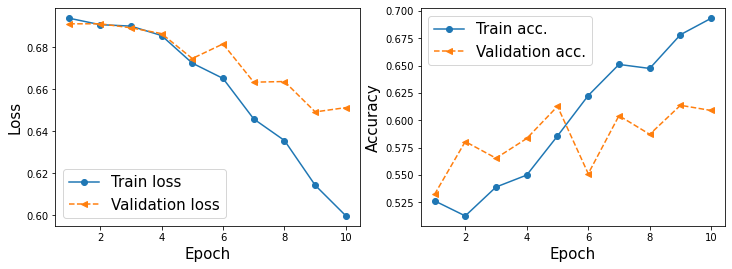

In [56]:
plot_train_valid(mlp_hist)

# Evaluation on test data for multilayer perceptron.

**Accuracy.**

In [58]:
mlp_results = mlp_model.evaluate(tfidf_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*mlp_results))

1/1 [==============================] - 0s 1ms/step - loss: 0.6254 - accuracy: 0.6600
Test loss: 0.6254   Test Acc.: 0.6600


**Confusion matrix**

In [0]:
def conf_matrix_plot(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, 
                    y=i, 
                    s=confmat[i, j], 
                    va='center', 
                    ha='center', 
                    size = 14)

    _ = plt.xlabel('predicted label', fontsize = 14)
    _ = plt.ylabel('true label', fontsize = 14)
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(fontsize = 14)
    _ = plt.tight_layout()
    return plt.show()

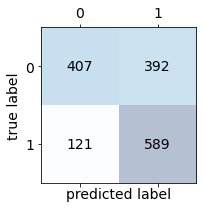

In [86]:
# Predicted labels
mlp_y_pred = mlp_model.predict_classes(tfidf_test.batch(test_size))

# Confusion matrix
mlp_confmat = confusion_matrix(y_true=tfidf_labels_true, 
                               y_pred=mlp_y_pred)

conf_matrix_plot(mlp_confmat)

**AUC score.**

In [77]:
print('AUC score for MLP on the test data:', 
      roc_auc_score(y_true = tfidf_labels_true, 
                    y_score = mlp_model.predict(tfidf_test.batch(test_size))[:,1]))

AUC score for MLP on the test data: 0.7335657247615859


**Classification report.**

In [79]:
print(classification_report(tfidf_labels_true, 
                            mlp_y_pred, 
                            target_names=['male', 'female']))

              precision    recall  f1-score   support

        male       0.77      0.51      0.61       799
      female       0.60      0.83      0.70       710

    accuracy                           0.66      1509
   macro avg       0.69      0.67      0.66      1509
weighted avg       0.69      0.66      0.65      1509



# Bidirectional LSTM network.





In [81]:
K.clear_session()
embedding_dim = rnn_input_shape
vocab_size = rnn_input_shape + 2

bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(150)), 
    
    tf.keras.layers.Dense(2, 
                          activation = 'softmax',
                          name = 'output')
])

bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 30)          960       
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               217200    
_________________________________________________________________
output (Dense)               (None, 2)                 602       
Total params: 218,762
Trainable params: 218,762
Non-trainable params: 0
_________________________________________________________________


In [0]:
bi_lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [83]:
bi_lstm_hist = fitting_neural_network(bi_lstm_model, 
                                      batch=8, 
                                      epochs=10, 
                                      ds_train_orig=rnn_train_orig, 
                                      ds_valid_orig=rnn_valid_orig)

Epoch 1/10
308/308 [==============================] - 3s 10ms/step - loss: 0.6370 - accuracy: 0.6315 - val_loss: 0.5864 - val_accuracy: 0.7576
Epoch 2/10
308/308 [==============================] - 2s 8ms/step - loss: 0.5253 - accuracy: 0.7642 - val_loss: 0.4930 - val_accuracy: 0.8097
Epoch 3/10
308/308 [==============================] - 2s 8ms/step - loss: 0.4462 - accuracy: 0.8145 - val_loss: 0.4243 - val_accuracy: 0.8333
Epoch 4/10
308/308 [==============================] - 2s 8ms/step - loss: 0.4090 - accuracy: 0.8364 - val_loss: 0.4056 - val_accuracy: 0.8381
Epoch 5/10
308/308 [==============================] - 2s 8ms/step - loss: 0.3884 - accuracy: 0.8438 - val_loss: 0.3911 - val_accuracy: 0.8352
Epoch 6/10
308/308 [==============================] - 2s 8ms/step - loss: 0.3803 - accuracy: 0.8421 - val_loss: 0.4002 - val_accuracy: 0.8409
Epoch 7/10
308/308 [==============================] - 2s 8ms/step - loss: 0.3826 - accuracy: 0.8458 - val_loss: 0.3754 - val_accuracy: 0.8447
Epoch

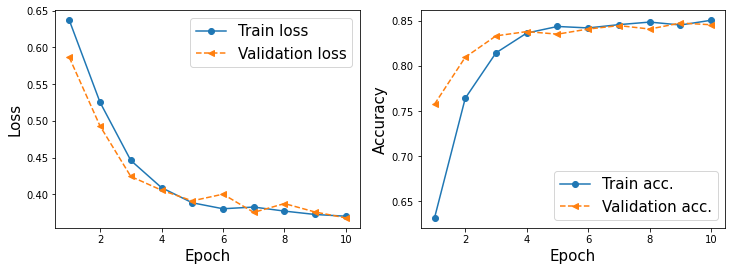

In [84]:
plot_train_valid(bi_lstm_hist)

# Evaluation on test data for bidirectional LSTM.

**Accuracy.**

In [85]:
bi_lstm_results = bi_lstm_model.evaluate(rnn_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*bi_lstm_results))

1/1 [==============================] - 0s 1ms/step - loss: 0.3965 - accuracy: 0.8403
Test loss: 0.3965   Test Acc.: 0.8403


**Confusion matrix.**

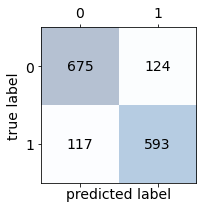

In [88]:
# Predicted labels
bi_lstm_y_pred = bi_lstm_model.predict_classes(rnn_test.batch(test_size))
bi_lstm_confmat = confusion_matrix(y_true=rnn_labels_true, 
                                   y_pred=bi_lstm_y_pred)

conf_matrix_plot(bi_lstm_confmat)

**AUC score.**

In [90]:
print('AUC score for LSTM network on the test data:', 
      roc_auc_score(y_true = rnn_labels_true, 
                    y_score = bi_lstm_model.predict(rnn_test.batch(test_size))[:,1]))

AUC score for LSTM network on the test data: 0.8993001815649844


**Classification report.**

In [92]:
print(classification_report(rnn_labels_true, 
                            bi_lstm_y_pred, 
                            target_names=['male', 'female']))

              precision    recall  f1-score   support

        male       0.85      0.84      0.85       799
      female       0.83      0.84      0.83       710

    accuracy                           0.84      1509
   macro avg       0.84      0.84      0.84      1509
weighted avg       0.84      0.84      0.84      1509



# Multiple bidirectional LSTMs with dropout layers.

In [94]:
K.clear_session()

model_multiple_lstms = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=rnn_input_shape + 2,
                              output_dim=rnn_input_shape),
    tf.keras.layers.Dense(100,
                          input_shape=(embedding_dim,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, 
                             return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100,
                             return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, 
                          activation='softmax')
])

print(model_multiple_lstms.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 30)          960       
_________________________________________________________________
dense (Dense)                (None, None, 100)         3100      
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0

In [0]:
model_multiple_lstms.compile(loss='sparse_categorical_crossentropy',
                             optimizer='adam',
                             metrics=['accuracy'])

In [96]:
model_multiple_lstms_hist = fitting_neural_network(model_multiple_lstms, 
                                                   batch=8, 
                                                   epochs=10, 
                                                   ds_train_orig=rnn_train_orig, 
                                                   ds_valid_orig=rnn_valid_orig)

Epoch 1/10
308/308 [==============================] - 5s 16ms/step - loss: 0.6471 - accuracy: 0.6128 - val_loss: 0.5148 - val_accuracy: 0.7746
Epoch 2/10
308/308 [==============================] - 4s 13ms/step - loss: 0.4804 - accuracy: 0.7898 - val_loss: 0.4333 - val_accuracy: 0.8229
Epoch 3/10
308/308 [==============================] - 4s 13ms/step - loss: 0.4161 - accuracy: 0.8332 - val_loss: 0.3864 - val_accuracy: 0.8485
Epoch 4/10
308/308 [==============================] - 4s 13ms/step - loss: 0.4010 - accuracy: 0.8433 - val_loss: 0.3846 - val_accuracy: 0.8551
Epoch 5/10
308/308 [==============================] - 4s 13ms/step - loss: 0.4048 - accuracy: 0.8385 - val_loss: 0.3943 - val_accuracy: 0.8475
Epoch 6/10
308/308 [==============================] - 4s 13ms/step - loss: 0.3945 - accuracy: 0.8425 - val_loss: 0.3812 - val_accuracy: 0.8447
Epoch 7/10
308/308 [==============================] - 4s 13ms/step - loss: 0.3898 - accuracy: 0.8397 - val_loss: 0.3826 - val_accuracy: 0.8504

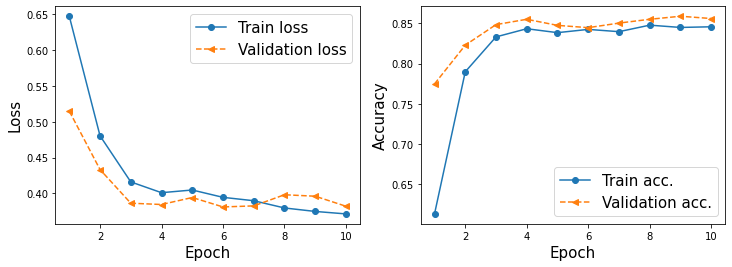

In [97]:
plot_train_valid(model_multiple_lstms_hist)

# Evaluation on test data for network with multiple LSTMs with dropout layers.

In [98]:
# evaluate model on the test data
model_multiple_lstms_results = model_multiple_lstms.evaluate(rnn_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*model_multiple_lstms_results))

1/1 [==============================] - 0s 1ms/step - loss: 0.4242 - accuracy: 0.8423
Test loss: 0.4242   Test Acc.: 0.8423


**Confusion matrix**

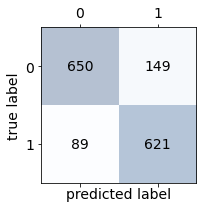

In [100]:
# Predicted labels
mult_lstm_y_pred = model_multiple_lstms.predict_classes(rnn_test.batch(test_size))
mult_lstm_confmat = confusion_matrix(y_true=rnn_labels_true, 
                                     y_pred=mult_lstm_y_pred)

conf_matrix_plot(mult_lstm_confmat)

**AUC score.**

In [101]:
print('AUC score for the network with multiple LSTMS and dropout layers on the test data:', 
      roc_auc_score(y_true = rnn_labels_true, 
                    y_score = model_multiple_lstms.predict(rnn_test.batch(test_size))[:,1]))

AUC score for the network with multiple LSTMS and dropout layers on the test data: 0.895670644643833


**Classiifcation report.**

In [102]:
print(classification_report(rnn_labels_true, 
                            mult_lstm_y_pred, 
                            target_names=['male', 'female']))

              precision    recall  f1-score   support

        male       0.88      0.81      0.85       799
      female       0.81      0.87      0.84       710

    accuracy                           0.84      1509
   macro avg       0.84      0.84      0.84      1509
weighted avg       0.85      0.84      0.84      1509

